**VC-theory**

Breakpoint: $\min n: m_{\mathcal{H}}(n) < 2^n$

VC-dimension: $d = n - 1$ where $n$ is the breakpoint.

Growth function: $m_{\mathcal{H}}(N) = \max_{x_1, \ldots, x_N}|\mathcal{H}(x_1, \ldots, x_N)|$

a) $h(x) = +1, x_i > a$

Breakpoint: there are $N + 1$ possible dichotomies for $N$ points (we can visualize this as having $N$ points on a line and trying to separate them into two groups: there are $N + 1$ ways to do that), thus we need to find an $n$ such that $n + 1 < 2^n$. 1 won't do, but $2 + 1 < 2^2$, so we have a breakpoint at $n = 2$.

VC-dimension: $d = n - 1 = 1$.

Growth function: $m_{\mathcal{H}}(N) = N + 1$, as explained above.

b) $h(x) = +1, a < x_i < b$

We separate the points into two categories: those that fit the hypothesis condition and those that don't. Once again, let's imagine a line where all our points reside (sorted by $x_i$). There is a singular case in which none of the points fit the condition. Now, imagine that at least one point satisfies the condition. There are at most $\frac{1}{2}n(n + 1)$ such cases. 

Thus, the growth function: $m_{\mathcal{H}}(N) = \frac{1}{2}N (N + 1) + 1$

Then the breakpoint is at $n = 3$, and VC-dimension is 2.


**Perceptron**

Training accuracy: 0.975
Test accuracy: 0.995


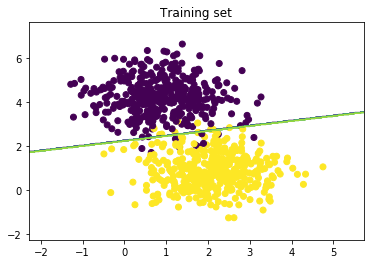

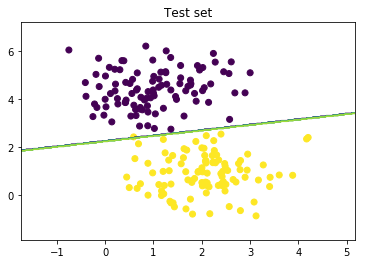

In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def predict(values, w):
    return ((np.dot(values, w)) > 0).astype(int)


def score(values, labels, w):
    return np.mean(labels == predict(values, w))


def pocket_perceptron_classify(training_values, training_labels, test_values, test_labels, max_iterations):
    w = np.random.rand(training_values.shape[1])
    best_w = None
    best_s = -math.inf

    for i in range(max_iterations):
        for j in range(len(training_values)):
            cur = predict(training_values[j], w)
            if cur != training_labels[j]:
                if training_labels[j] == 1:  
                    w += training_values[j]
                else:  # instead of mapping values to {-1, +1} we do this
                    w -= training_values[j]
                cur_s = score(test_values, test_labels, w)
                if cur_s > best_s:
                    best_w = w.copy()
    return best_w


def plot_perceptron(values, labels, w, degree, title=""):
    plt.scatter(values[:, 1], values[:, 2], c=labels)

    min_x = np.min(values[:, 1]) - 1
    max_x = np.max(values[:, 1]) + 1
    min_y = np.min(values[:, 2]) - 1
    max_y = np.max(values[:, 2]) + 1
    x, y = np.meshgrid(np.arange(min_x, max_x, 0.03), np.arange(min_y, max_y, 0.03))

    features = PolynomialFeatures(degree).fit_transform(np.c_[x.reshape(-1), y.reshape(-1)])
    z = predict(features, w).reshape(x.shape)

    plt.title(title)
    plt.contour(x, y, z)
    plt.show()


def classify_for_degree(degree, training_values, test_values, training_labels, test_labels):
    training_values = PolynomialFeatures(degree=degree).fit_transform(training_values)
    test_values = PolynomialFeatures(degree=degree).fit_transform(test_values)

    w = pocket_perceptron_classify(training_values, training_labels, test_values, test_labels, 1000)
    train_acc = score(training_values, training_labels, w)
    test_acc = score(test_values, test_labels, w)
    print("Training accuracy: " + str(train_acc))
    print("Test accuracy: " + str(test_acc))
    plot_perceptron(training_values, training_labels, w, degree, "Training set")
    plot_perceptron(test_values, test_labels, w, degree, "Test set")

dataset = pd.read_csv("blobs2.csv")
values = dataset.drop('label', axis=1).to_numpy()
labels = dataset['label'].to_numpy()
training_values, test_values, training_labels, test_labels = train_test_split(values, labels, test_size=0.2)
classify_for_degree(1, training_values, test_values, training_labels, test_labels)    

Training accuracy: 0.97125
Test accuracy: 0.975


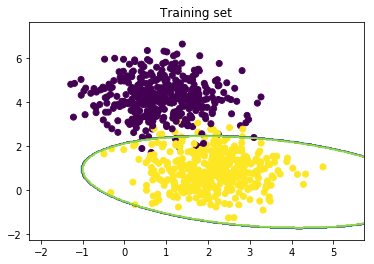

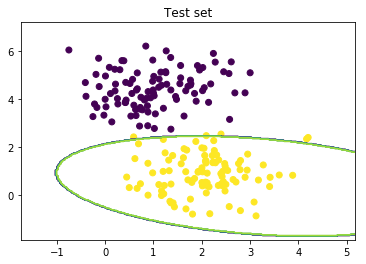

In [8]:
# if I understood correctly, PolynomialFeatures applies the very same transformation that was described in the task?
classify_for_degree(2, training_values, test_values, training_labels, test_labels)    

Training accuracy: 0.9725
Test accuracy: 0.975


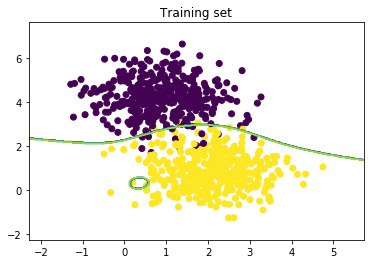

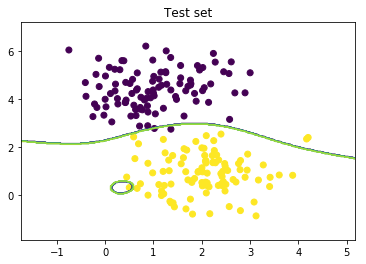

In [9]:
classify_for_degree(3, training_values, test_values, training_labels, test_labels)    

Training accuracy: 0.96
Test accuracy: 0.975


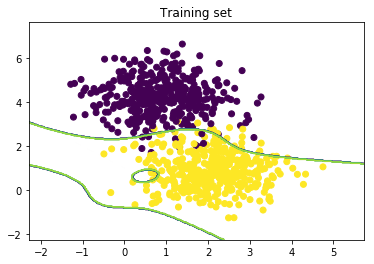

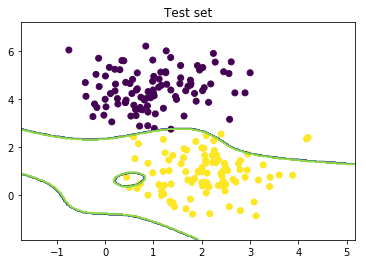

In [10]:
classify_for_degree(4, training_values, test_values, training_labels, test_labels)    

**Logistic regression**

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import logistic
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures


def predict(values, w):
    predicted = (logistic.cdf(np.dot(values, w)) > 0.5).astype(int)
    predicted[predicted == 0] = -1
    return predicted


def score(values, labels, w):
    return np.mean(labels == predict(values, w))


def logistic_regression(values, labels, epoch_num=500, learning_rate=0.02):
    values = PolynomialFeatures(1).fit_transform(values)

    w = np.random.rand(values.shape[1])

    scores = np.empty(epoch_num)
    batches = np.array_split(np.arange(len(values)), len(values) / 20)

    for epoch in range(epoch_num):
        for batch in batches:
            gradient = 0
            for i in batch:
                gradient += labels[i] * values[i] / (1 + np.exp(labels[i] * np.dot(values[i], w)))
            w += gradient / len(batch) * learning_rate
        scores[epoch] = score(values, labels, w)

    return scores


def plot_accuracies(accuracies):
    plt.plot(range(len(accuracies)), accuracies)
    plt.show()


def process_dataset(filename, first_label, second_label):
    dataset = pd.read_csv(filename)
    values = dataset.drop('label', axis=1).to_numpy()
    labels = dataset['label'].to_numpy()
    values = MinMaxScaler().fit_transform(values)
    labels_map = {first_label: 1, second_label: -1}
    for i in range(len(labels)):
        labels[i] = labels_map[labels[i]]
    accuracies = logistic_regression(values, labels)
    plot_accuracies(accuracies)

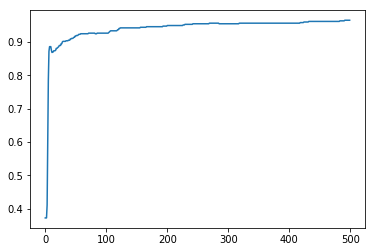

In [18]:
process_dataset('cancer.csv', 'M', 'B')

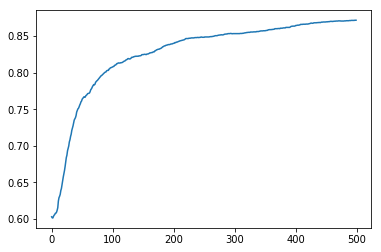

In [21]:
process_dataset('spam.csv', 1, 0)

**Neural networks**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
from skimage import io


dataset_mnist = pd.read_csv('mnist.csv')
values_mnist = torch.IntTensor(dataset_mnist.values[:, 1:].reshape(-1, 28, 28))[:, None, :, :]
labels_mnist = torch.IntTensor(dataset_mnist.values[:, 0])


In [4]:
def modify_labels(labels):
    new_labels = np.copy(labels)
    unique_labels = np.sort(np.unique(np.array(labels)))
    for i in range(len(unique_labels)):
        new_labels[new_labels == unique_labels[i]] = i
    return torch.IntTensor(new_labels.astype(int))


def read_data(path):
    labels = []
    images = []
    for label in sorted(os.listdir(path)):
        for root, dirs, files in os.walk(os.path.join(path, label)):
            labels.extend([label for i in files])
            images.extend([os.path.abspath(os.path.join(root, file)) for file in files])
    return modify_labels(labels), images


def get_image_tensor(images, i):
    return torch.FloatTensor(io.imread(images[i]))[None, :, :]

    

In [8]:
labels_notmnist, images_notmnist = read_data('notMNIST_small')

In [ ]:
# now let's create classes for these methods in order for pytorch to work with our datasets

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from skimage import io
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class MnistDataset(Dataset):
    def __init__(self):
        super().__init__()
        dataset = pd.read_csv('mnist.csv')
        self.values = torch.FloatTensor(dataset.values[:, 1:].reshape(-1, 28, 28))[:, None, :, :]
        self.labels = torch.LongTensor(dataset.values[:, 0])

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, item):
        return self.values[item], self.labels[item]


class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, activation_function):
        super(ConvolutionNeuralNetwork, self).__init__()
        self.activation_function = activation_function
        self.layer1 = nn.Conv2d(1, 8, 3)
        self.layer2 = nn.Conv2d(8, 8 ** 2, 3)
        self.layer3 = nn.Conv2d(8 ** 2, 8 ** 3, 3)
        convoluted_image_size = 28 - 3 * (3 - 1)  # three convolutions
        self.fc1 = nn.Linear(8 ** 3 * convoluted_image_size ** 2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        self.fc3(x)
        return nn.LogSoftmax(dim=1)(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


def train_network(network, dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
    epochs = 15
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    correct = 0
    total = 0
    for epoch in range(epochs):
        for data in loader:
            values, labels = data
            optimizer.zero_grad()
            out = network(values)
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
        print('Epoch %i accuracy: %d %%' % (epoch, (100 * correct / total)))

In [24]:
mnist = MnistDataset()
print('sigmoid')
train_network(ConvolutionNeuralNetwork(nn.Sigmoid()), mnist)

sigmoid
Epoch 0 accuracy: 55 %
Epoch 1 accuracy: 65 %
Epoch 2 accuracy: 70 %
Epoch 3 accuracy: 74 %
Epoch 4 accuracy: 76 %
Epoch 5 accuracy: 78 %
Epoch 6 accuracy: 79 %
Epoch 7 accuracy: 79 %
Epoch 8 accuracy: 80 %
Epoch 9 accuracy: 80 %
Epoch 10 accuracy: 80 %
Epoch 11 accuracy: 81 %
Epoch 12 accuracy: 81 %
Epoch 13 accuracy: 81 %
Epoch 14 accuracy: 80 %


In [25]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, activation_function):
        super(ConvolutionNeuralNetwork, self).__init__()
        self.activation_function = activation_function
        self.layer1 = nn.Conv2d(1, 8, 3)
        self.layer2 = nn.Conv2d(8, 8 ** 2, 3)
        self.layer3 = nn.Conv2d(8 ** 2, 8 ** 3, 3)
        convoluted_image_size = 28 - 3 * (3 - 1)  # three convolutions
        self.fc1 = nn.Linear(8 ** 3 * convoluted_image_size ** 2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.activation_function(self.layer1(x))
        x = self.activation_function(self.layer2(x))
        x = self.activation_function(self.layer3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        self.fc3(x)
        return nn.LogSoftmax(dim=1)(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

print('RelU')
train_network(ConvolutionNeuralNetwork(nn.ReLU()), mnist)

RelU
Epoch 0 accuracy: 71 %
Epoch 1 accuracy: 83 %
Epoch 2 accuracy: 88 %
Epoch 3 accuracy: 91 %
Epoch 4 accuracy: 92 %
Epoch 5 accuracy: 93 %
Epoch 6 accuracy: 94 %
Epoch 7 accuracy: 95 %
Epoch 8 accuracy: 95 %
Epoch 9 accuracy: 96 %
Epoch 10 accuracy: 96 %
Epoch 11 accuracy: 96 %
Epoch 12 accuracy: 97 %
Epoch 13 accuracy: 97 %
Epoch 14 accuracy: 97 %


In [26]:
print('Tanh')
train_network(ConvolutionNeuralNetwork(nn.Tanh()), mnist)

Tanh
Epoch 0 accuracy: 72 %
Epoch 1 accuracy: 80 %
Epoch 2 accuracy: 83 %
Epoch 3 accuracy: 85 %
Epoch 4 accuracy: 87 %
Epoch 5 accuracy: 88 %
Epoch 6 accuracy: 89 %
Epoch 7 accuracy: 90 %
Epoch 8 accuracy: 90 %
Epoch 9 accuracy: 91 %
Epoch 10 accuracy: 91 %
Epoch 11 accuracy: 92 %
Epoch 12 accuracy: 92 %
Epoch 13 accuracy: 92 %
Epoch 14 accuracy: 93 %


**notMNIST**

In [ ]:
# draft
from skimage import io
import numpy as np
import os
import random
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn


class notMNIST(Dataset):
    def __init__(self, root):
        images = []
        labels = []
        folders = os.listdir(root)

        for folder in sorted(folders):
            folder_path = os.path.join(root, folder)
            for ims in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, ims)
                    images.append(np.array(io.imread(img_path)))
                    labels.append(ord(folder) - 65)  # A-J -> 0-9
                except:
                    print("Unable to read {}/{}".format(folder, ims))
        data = [(x, y) for x, y in zip(images, labels)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        img = img.reshape(28, 28) / 255.0
        img_tensor = torch.Tensor(img).view(1, 28, 28).float()
        label = self.data[index][1]
        return img_tensor, label


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x


notmnist = notMNIST('notMNIST_small')
validation_split = 0.2
batch_size = 256
dataset_size = len(notmnist)
indices = list(range(dataset_size))
random.shuffle(indices)
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = sorted(indices[split:]), sorted(indices[:split])

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(notmnist, batch_size=1, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(notmnist, batch_size=1, sampler=valid_sampler)

net = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters())
BATCH_SIZE = 256
N_EPOCHS = 50

loss_history = []


def train(epoch):
    epoch_loss = 0
    n_batches = len(train_loader.dataset) // BATCH_SIZE

    for step, data in enumerate(train_loader, 0):
        train_x, train_y = data
        y_hat = net.forward(train_x)
        train_y = torch.Tensor(np.array(train_y))
        loss = criterion(y_hat, train_y.long())
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % n_batches == 0 and step != 0:
            epoch_loss = epoch_loss / n_batches
            loss_history.append(epoch_loss)
            print("Epoch {}, loss {}".format(epoch, epoch_loss))
            epoch_loss = 0


for epoch in range(1, N_EPOCHS + 1):
    train(epoch)


classifier = net.eval()
correct = 0

for _, data in enumerate(test_loader, 0):
    test_x, test_y = data
    pred = classifier.forward(test_x)
    y_hat = np.argmax(pred.data)
    if y_hat == test_y:
        correct += 1

print("Accuracy={}".format(correct / len(test_loader.dataset)))